# Imports

In [ ]:
import os
import sys
import time
import math
import gzip
import json
import itertools
import importlib
from pathlib import Path
import csv
import re
import numpy as np
import asyncpg
import glob
import gzip
import pandas as pd
import matplotlib.pyplot as plt

import edcompanion.edsm_api
from edcompanion.calctools import *

def prettyprint(item):
    print(json.dumps(item, indent=4, sort_keys=False))


In [ ]:

pgsql_params = dict(
    dsn=os.getenv("PGSQL_URL"),
    server_settings={'search_path': "edsm"}
)
pgpool = await asyncpg.create_pool(**pgsql_params)

In [ ]:
print(await pgpool.fetch("SELECT * FROM edsm.systems WHERE name = $1", "Ix"))

# Setting up the big cubes

In [ ]:
data = []
count = 0

for cy in range(-3000, 3000, 200): # n=30
    count += 1
    qr = await pgpool.copy_records_to_table("volumes", records=[(cx,cy,cz)  for cx in range(-30000, 30000, 200) for cz in range(-24000, 66000,200)])
    print(f"{count}/{30}\t{round(100*count/30,2)}%")



In [ ]:
# Add column with distance to Sol
await pgpool.execute("""
    ALTER TABLE edsm.volumes ADD COLUMN distance integer; 
""")

In [ ]:
await pgpool.execute("""
    UPDATE  edsm.volumes 
    SET distance = |/((c200x+100)^2 + (c200y+100)^2 + (c200z+100)^2); 
""")

In [ ]:
assert False, "Only run after recreating The Voids"
qr = await pgpool.fetch("""
    SELECT v.*
    FROM edsm.volumes v
    LEFT JOIN edsm.systems s
    ON v.c200x = s.c200x AND v.c200y = s.c200y AND v.c200z = s.c200z 
    WHERE s.name IS NULL
    """)

await pgpool.copy_records_to_table("voids", records=qr)

In [ ]:
# Add column with distance to Sol
await pgpool.execute("""
    ALTER TABLE edsm.voids ADD COLUMN distance integer; 
""")

In [ ]:
await pgpool.execute("""
    UPDATE  edsm.voids 
    SET distance = |/((c200x+100)^2 + (c200y+100)^2 + (c200z+100)^2); 
""")

# scratchpad


In [1]:
import sys
import time
from pathlib import Path
import gzip
import json
# systemsWithCoordinates7days
def edc_dbfilereader(filename, verbose=False):
    """
        Opens 'filename' as generator for eddb style objects
    """

    filesize=Path(filename).stat().st_size
    chunksize = 64 * 1024 * 1024
    est_count = int(6.7*filesize/chunksize) + 1
    print(f"Reading {filename}, {round(filesize/(1024*1024),1)} Mb in approx {est_count} chunks")

    count = 0
    system_count = 0
    item = None

    start = time.process_time()
    #try:

    with gzip.open(filename, 'rt') as jsonfile:

        while True:
            count += 1
            chunk = jsonfile.readlines(chunksize)
            if chunk:
                for line in chunk:
                    if len(line) < 5:
                        continue

                    yield json.loads(line.rstrip(',\n\r '))

                    system_count += 1

                yield {}
                sys.stdout.write(f"\r{count}/{est_count}\t{100*count/est_count:3.2f}%, {int(system_count / (time.process_time() - start)):6} /s, {system_count:9} systems, {((est_count - count) * (time.process_time() - start)/count):5.1f} seconds remaining")

            else:
                print(f"\nEmpty chunk -> Done! Imported {system_count} systems in {round(time.process_time() - start,1)} seconds")
                break

    tpl = (time.process_time() - start)/system_count
    sys.stdout.write(f"\n{ (time.process_time() - start)} seconds {system_count} systems, per system {round(1000000*tpl,2)} us")


In [ ]:
print(f"Adding indexes ...")
await pgpool.execute(f"""
    CREATE INDEX IF NOT EXISTS systems_x_idx ON edsm.systems (x);
    CREATE INDEX IF NOT EXISTS systems_y_idx ON edsm.systems (y);
    CREATE INDEX IF NOT EXISTS systems_z_idx ON edsm.systems (z); 
    CREATE INDEX IF NOT EXISTS systems_name_idx ON edsm.systems (name);
""")

In [2]:
dataset = []
for item in edc_dbfilereader('data/systemsWithCoordinates7days.json.gz'):
    dataset.append(item)

Reading data/systemsWithCoordinates7days.json.gz, 3.8 Mb in approx 1 chunks
1/1	100.00%, 278348 /s,    107960 systems,   0.0 seconds remaining
Empty chunk -> Done! Imported 107960 systems in 0.4 seconds

0.3896619339999998 seconds 107960 systems, per system 3.61 us

In [5]:
dataset = []
for item in edc_dbfilereader('data/galaxy_1day.json.gz'):
    dataset.append(item)

Reading data/galaxy_1day.json.gz, 806.2 Mb in approx 85 chunks
77/85	90.59%,   1671 /s,     88920 systems,   5.5 seconds remaining
Empty chunk -> Done! Imported 88920 systems in 53.2 seconds

53.197364236 seconds 88920 systems, per system 598.26 us

In [7]:
dataset = []
for item in edc_dbfilereader('data/systems_1day.json.gz'):
    dataset.append(item)

Reading data/systems_1day.json.gz, 2.5 Mb in approx 1 chunks
1/1	100.00%, 380531 /s,     76758 systems,   0.0 seconds remaining
Empty chunk -> Done! Imported 76758 systems in 0.2 seconds

0.2028567910000021 seconds 76758 systems, per system 2.64 us

In [8]:
dataset[0]

{'id64': 2326687,
 'name': 'HD 192281',
 'mainStar': 'O (Blue-White) Star',
 'coords': {'x': -4023.53125, 'y': 230.875, 'z': 896.46875},
 'updateTime': '2024-04-13 21:57:30+00'}

In [ ]:


await pgpool.execute("""
    ALTER TABLE edsm.systems ADD COLUMN N boolean default false; 
""")

In [ ]:
#filename = "data/galaxy_7days.json.gz"
filename=os.path.join('f:', os.sep, 'data', 'eddb', 'galaxy_1month-2023-01-03.json'+'.gz')

In [ ]:
data = []
updated = 0

for item in edc_dbfilereader(filename):
    if not item:
        #qr = await pgpool.copy_records_to_table("systems", records=data)
        qr = await pgpool.executemany(
            """INSERT INTO edsm.systems (name, x, y, z, n) 
                VALUES ($1, $2, $3, $4, $5) 
                ON CONFLICT (name) DO UPDATE SET n=$5, x=$2, y=$3, z=$4
            """, data)
        updated += len(data)
        data = []
        time.sleep(4)
        continue

    bodies = item.get('bodies',[{}])

    neutron = [bool(B.get('subType','')=='Neutron Star') for B in bodies if B.get('mainStar')]        
    coords = item.get('coords')
    #coordinates = [coords[k] for k in ['x','y','z']]
    data.append(
        [
            item.get('name'), 
            *[coords[k] for k in ['x','y','z']],
            bool(bool(neutron) and all(neutron))
        ]
        #[item.get('name')] + [coords[k] for k in ['x','y','z']] + [len(neutron)>0 and all(neutron)]
    )
print(f"\nUpdated {updated} systems with neutron star primary")

In [ ]:
#filename = "data/galaxy_7days.json.gz"
filename=os.path.join('f:', os.sep, 'data', 'eddb', 'galaxy.json'+'.gz')

In [ ]:
data = []
updated = 0

for item in edc_dbfilereader(filename):
    if not item:
        #qr = await pgpool.copy_records_to_table("systems", records=data)
        qr = await pgpool.executemany(
            """INSERT INTO edsm.systems (name, x, y, z, n) 
                VALUES ($1, $2, $3, $4,TRUE) 
                ON CONFLICT (name) DO UPDATE SET n = TRUE
            """, data)
        updated += len(data)
        data = []
        time.sleep(2)
        continue

    bodies = item.get('bodies',[{}])
    if bodies:
    
        #mainstar = [B.get('subType','-')[0] for B in bodies if B.get('mainStar')]
        neutron = [bool(B.get('subType','')=='Neutron Star') for B in bodies if B.get('mainStar')]
        if bool(neutron) and all(neutron):
            coords = item.get('coords')
            #coordinates = [coords[k] for k in ['x','y','z']]
            data.append(
                [
                    item.get('name'), 
                    *[coords[k] for k in ['x','y','z']]
                ]
                #[item.get('name')] + [coords[k] for k in ['x','y','z']] + [len(neutron)>0 and all(neutron)]
            )

print(f"\nUpdated {updated} systems with neutron star primary")

In [ ]:
82/1000000 * 70000000

# Reading EDSM json



## Systems

In [ ]:
filename = "data/systemsWithCoordinates.json.gz"

# 2022-04-17: 552.40625 seconds 70750837 systems, per system 7.81 us, est: 404.86962424380926
# 2022-04-10: 882.5625 seconds 70583001 systems, per system 12.5 us, est: 648.3858730978299
#  with 900 duplicate systems
#assert False, "Completed, don't do this again unless you've dropped and recreated the table"

# Drop te existing table:
await pgpool.execute(f"DROP TABLE edsm.systems;")
await pgpool.execute(f"""
    CREATE TABLE IF NOT EXISTS edsm.systems (
        name text NOT NULL,
        x DOUBLE PRECISION,
        y DOUBLE PRECISION,
        z DOUBLE PRECISION
    );
""")


filesize=Path(filename).stat().st_size
chunksize = 64 * 1024 * 1024
est_count = int(8*filesize/chunksize) + 1
print(f"Reading {filename}, {round(filesize/(1024*1024),1)} Mb in approx {est_count} chunks")

count = 0
system_count = 0
columns = slice(2,6)
start = time.process_time()
with gzip.open(filename, 'rt') as jsonfile:

    firstline = jsonfile.readline()

    while True:
        count += 1
        chunk = jsonfile.readlines(chunksize)
        if chunk:
            data = []
            for line in chunk:
                if len(line) < 5:
                    continue
                item = json.loads(line[0:-2]) if line[-2] == "," else json.loads(line)
                coords = item.get('coords')
                coordinates = [coords[k] for k in coords]
                data.append(
                    [item.get("name")] + coordinates #+
                    #[int(20*math.floor(v/20)) for v in coordinates] +
                    #[int(200*math.floor(v/200)) for v in coordinates]
                )
                
            qr = await pgpool.copy_records_to_table("systems", records=data)
            system_count += len(data)
            sys.stdout.write(f"{count}/{est_count}\t{100*count/est_count:3.2f}%, {int(system_count / (time.process_time() - start)):6} /s, {system_count:9} systems, {((est_count - count) * (time.process_time() - start)/count):5.1f} seconds remaining\r")
            #print(f"{count}/{est_count}\t{round(100*count/est_count,2)}%,\t{int(system_count / (time.process_time() - start))} /s,\t{system_count} systems, \t{round(((est_count - count) * (time.process_time() - start)/count),1)} seconds remaining")
            
        else:    
            print(f"\nEmpty chunk -> Done! Imported {system_count} systems in {round(time.process_time() - start,1)} seconds")
            break

            

tpl = (time.process_time() - start)/system_count
print(f"{ (time.process_time() - start)} seconds {system_count} systems, per system {round(1000000*tpl,2)} us") 

In [ ]:
pd.DataFrame(data)

In [ ]:
print(f"Adding indexes ...")
await pgpool.execute(f"""
    CREATE INDEX IF NOT EXISTS systems_x_idx ON edsm.systems (x);
    CREATE INDEX IF NOT EXISTS systems_y_idx ON edsm.systems (y);
    CREATE INDEX IF NOT EXISTS systems_z_idx ON edsm.systems (z); 
    CREATE INDEX IF NOT EXISTS systems_name_idx ON edsm.systems (name);
""")

In [ ]:
print("Removing duplicates by system name")
await pgpool.execute("""
    DELETE FROM edsm.systems a
    WHERE   a.ctid <> (SELECT min(b.ctid)
                     FROM   edsm.systems b
                     WHERE  a.name = b.name );"""
)

In [ ]:
print(f"Adding unique index on system name ...")
await pgpool.execute(f"""
    DROP INDEX systems_name_idx ;
    CREATE UNIQUE INDEX IF NOT EXISTS systems_name_unique ON edsm.systems (name)
""")

### Update

In [ ]:
glob.glob(os.path.join('data', "systemsWithCoordinates7days-*.json.gz"))

In [ ]:

start = time.process_time()

for filename in sorted(glob.glob(os.path.join('data', "systemsWithCoordinates7days-*.json.gz"))):
    
    filesize=Path(filename).stat().st_size
    chunksize = 4 * 1024 * 1024
    est_count = int(8*filesize/chunksize) + 1
    print(f"Reading {filename}, {round(filesize/(1024*1024),1)} Mb in approx {est_count} chunks")

    count = 0
    system_count = 0
    columns = slice(2,6)
    data=[]

    with gzip.open(filename, 'rt') as jsonfile:

        firstline = jsonfile.readline()

        while True:
            count += 1
            chunk = jsonfile.readlines(chunksize)
            if chunk:
                data = []
                for line in chunk:
                    if len(line) < 5:
                        continue
                    item = json.loads(line[0:-2]) if line[-2] == "," else json.loads(line)

                    coords = item.get('coords')
                    coordinates = [coords[k] for k in coords]
                    data.append(
                        [item.get("name")] + coordinates #+
                        #[int(20*math.floor(v/20)) for v in coordinates] +
                        #[int(200*math.floor(v/200)) for v in coordinates]
                    )

                qr = await pgpool.executemany(
                    """INSERT INTO edsm.systems (name, x, y, z) 
                        VALUES ($1, $2, $3, $4) 
                        ON CONFLICT DO NOTHING
                    """, data)
                system_count += len(data)
                sys.stdout.write(f"{count}/{est_count}\t{100*count/est_count:3.2f}%, {int(system_count / (time.process_time() - start)):6} /s, {system_count:9} systems, {((est_count - count) * (time.process_time() - start)/count):5.1f} seconds remaining\r")
                #print(f"{count}/{est_count}\t{round(100*count/est_count,2)}%,\t{int(system_count / (time.process_time() - start))} /s,\t{system_count} systems, \t{round(((est_count - count) * (time.process_time() - start)/count),1)} seconds remaining")
                continue

            print(f"\nEmpty chunk -> Done! Imported {system_count} systems in {round(time.process_time() - start,1)} seconds")
            break



tpl = (time.process_time() - start)/system_count
print(f"{ (time.process_time() - start)} seconds {system_count} systems, per system {round(1000000*tpl,2)} us, est: {tpl*51854708}") 

### Populated systems 

In [ ]:
filename = "data/systemsPopulated.json.gz"

filesize=Path(filename).stat().st_size
chunksize = 64 * 1024 * 1024
est_count = int(8*filesize/chunksize) + 1
print(f"Reading {filename}, {round(filesize/(1024*1024),1)} Mb in approx {est_count} chunks")

count = 0
system_count = 0
columns = slice(2,6)
start = time.process_time()
with gzip.open(filename, "rt") as jsonfile:
    firstline = jsonfile.readline()

    while True:
        count += 1
        chunk = jsonfile.readlines(chunksize)
        if chunk:
            data = []
            for line in chunk:
                if len(line) < 5:
                    continue
                item = json.loads(line[0:-2]) if line[-2] == "," else json.loads(line)
                data.append(
                    [item.get("name"), float(item.get("population") if item.get("population") else 0.0), item.get('security')]
                )

            qr = await pgpool.executemany(
                """INSERT INTO edsm.populated (systemname, population, security) 
                    VALUES ($1, $2, $3) 
                    ON CONFLICT (systemname) DO UPDATE SET 
                        population = $2,
                        security = $3
                """, data)
            #qr = await pgpool.copy_records_to_table("populated", records=data)
            system_count += len(data)
            print(f"{count}/{est_count}\t{round(100*count/est_count,2)}%,\t{int(system_count / (time.process_time() - start))} /s,\t{system_count} systems, \t{round(((est_count - count) * (time.process_time() - start)/count),1)} seconds remaining")
            continue
            
        print(f"Empty chunk -> Done! Imported {system_count} systems in {round(time.process_time() - start,1)} seconds")
        break

            

tpl = (time.process_time() - start)/system_count
print(f"{ (time.process_time() - start)} seconds {system_count} systems, per system {round(1000000*tpl,2)} us, est: {tpl*51854708}") 

In [ ]:
item

### Powerplay

In [ ]:
filename = "data/powerPlay.json.gz"

filesize=Path(filename).stat().st_size
chunksize = 64 * 1024 * 1024
est_count = int(8*filesize/chunksize) + 1
print(f"Reading {filename}, {round(filesize/(1024*1024),1)} Mb in approx {est_count} chunks")

count = 0
system_count = 0
columns = slice(2,6)
start = time.process_time()
with gzip.open(filename, 'rt') as jsonfile:
    firstline = jsonfile.readline()

    while True:
        count += 1
        chunk = jsonfile.readlines(chunksize)
        if chunk:
            data = []
            for line in chunk:
                if len(line) < 5:
                    continue
                item = json.loads(line[0:-2]) if line[-2] == "," else json.loads(line)
                data.append(
                    [item.get(k) for k in ["power", "name","powerState","allegiance"]] 
                )
                
            qr = await pgpool.executemany(
                """INSERT INTO edsm.powers (power, systemname, powerstate, allegiance) 
                    VALUES ($1, $2, $3, $4) 
                    ON CONFLICT (power, systemname) DO UPDATE SET 
                        powerstate = $3,
                        allegiance = $4
                """, data)
            system_count += len(data)
            print(f"{count}/{est_count}\t{round(100*count/est_count,2)}%,\t{int(system_count / (time.process_time() - start))} /s,\t{system_count} systems, \t{round(((est_count - count) * (time.process_time() - start)/count),1)} seconds remaining")
            continue
            
        print(f"Empy chunk -> Done! Imported {system_count} systems in {round(time.process_time() - start,1)} seconds")
        break

            

tpl = (time.process_time() - start)/system_count
print(f"{ (time.process_time() - start)} seconds {system_count} systems, per system {round(1000000*tpl,2)} us, est: {tpl*51854708}") 

In [ ]:
item

## Get data from logs

In [ ]:
logpath = "/Users/fenke/Saved Games/Frontier Developments/Elite Dangerous"
logfiles = glob.glob(os.path.join(logpath, "journal.*"))

last_system = {
    "timestamp": "2000-01-01",
    "StarSystem": None
}
data = {}
events = {}
jumps = {}
scans = {}
bodies = {}
systems = {}

scan_events = set([
        "SAAScanComplete",
        "SAASignalsFound",
        "Scan",
        "FSSDiscoveryScan",
        #"FSSSignalDiscovered",
        "FSSAllBodiesFound",
        "FSDJump"
    ])
jump_events = set([
    "StartJump",
    "FSDJump",
    "FuelScoop"
])
excluded_events = set([
    "ReceiveText",
    "Location",
    "Commander",
    "Materials",
    "Rank",
    "Progress",
    "Reputation",
    "LoadGame",
    "EngineerProgress",
    "Music",
    "Missions",
    "Loadout",
    "Music",
    "Statistics",
    "Cargo",
    "SupercruiseEntry"
])

async with pgpool.acquire() as pgconnection: 
    prepped_query = await pgconnection.prepare(
        """INSERT INTO edsm.systems (name, x, y, z) 
            VALUES ($1, $2, $3, $4) 
            ON CONFLICT DO NOTHING
        """
    )

    columns = slice(2,6)
    start = time.process_time()
    system_count = 0
    for filename in logfiles[-9:]:

        filesize=Path(filename).stat().st_size
        chunksize = 1 * 1024 * 1024
        est_count = int(filesize/chunksize) + 1
        #print(f"Reading {filename}, {round(filesize/(1024*1024),1)} Mb in approx {est_count} chunks")
        count = 0

        with open(filename, "rt") as jsonfile:
            firstline = jsonfile.readline()

            while True:
                count += 1
                chunk = jsonfile.readlines(chunksize)
                if chunk:
                    #data = []
                    for line in chunk:
                        if len(line) < 5:
                            continue
                        item = json.loads(line[0:-2]) if line[-2] == "," else json.loads(line)
                        if item.get("event") in excluded_events:
                            continue
                            
                        timestamp = item.get("timestamp")
                        eventname = item.get("event")
                        system_name = item.get("SystemName", item.get("StarSystem"))
                        if system_name and system_name not in systems:
                            systems[system_name] = dict(bodies=dict())
                            system = systems[system_name]
                        
                        if eventname in jump_events and item.get("JumpType") != "Supercruise":
                            if timestamp not in jumps:
                                jumps[timestamp] = []
                            jump = jumps.get(timestamp)
                            jump.append(item)
                            
                        elif eventname in scan_events:
                            body_name = item.get("BodyName")
                            if body_name not in bodies:
                                bodies[body_name] = {}
                            body = bodies[body_name]
                            
                            if system_name and body_name and body_name not in system["bodies"]:
                                system["bodies"][body_name] = body
                                
                            
                            for key in ["StarSystem", "DistanceFromArrivalLS","ProbesUsed", "WasDiscovered", "WasMapped", "Landable"]: # items
                                body[key] = item.get(key, body.get(key, None))
                            
                            #for key in ["Signals", "Materials"]: # lists
                            
                            if timestamp not in scans:
                                scans[timestamp] = []
                            scan = scans.get(timestamp)
                            scan.append(item)
                            
                        else:
                            if timestamp not in events:
                                events[timestamp] = []
                            event = events.get(timestamp)
                            event.append(item)
                        
                        if item.get("event") == "FSDJump":
                            coordinates = item.get('StarPos')
                            data[item.get("StarSystem")] = coordinates + [int(20*math.floor(v/20)) for v in coordinates] +  [int(200*math.floor(v/200)) for v in coordinates]
                            if timestamp > last_system.get("timestamp"):
                                last_system = {k:item[k] for k in last_system }
                            
                        #all_events.append(item.get("event"))
                        #data.append( [item.get(k) for k in ["name","systemName", "type","distanceToArrival"]]  )
                    continue # -> while


                #print(f"Empy chunk -> Done! Imported {system_count} systems in {round(time.process_time() - start,1)} seconds")
                break
                
        #await prepped_query.executemany([[S] + data[S] for S in data])
        system_count += len(data)
        data = {}
        
    #print(f"{count}/{est_count}\t{system_count}\tsystems,\t{int(system_count / (time.process_time() - start))} /s,\t{round(100*count/est_count,2)}%, {round(((est_count - count) * (time.process_time() - start)/count),1)} remaining")


    if system_count > 0:
        tpl = (time.process_time() - start)/system_count
        print(f"{ (time.process_time() - start)} seconds {system_count} systems, per system {round(1000000*tpl,2)} us, est: {tpl*51854708}") 

In [ ]:
{T:jumps[T] for T in jumps if jumps[T][0]['event']=='FSDJump'}

In [ ]:
jumps

In [ ]:
prettyprint(systems)

In [ ]:
prettyprint(scans)

In [ ]:
prettyprint(last_system)
prettyprint([R.get("name") for R in await find_nearby_systems(last_system.get("StarSystem"), 10) ])

## Removing Duplicates

### One query to remove them all

In [ ]:
await pgpool.execute("""
    DELETE FROM edsm.systems a
    WHERE   a.ctid <> (SELECT min(b.ctid)
                     FROM   edsm.systems b
                     WHERE  a.name = b.name );"""
)

### Another ONE bites the dust

In [ ]:
await pgpool.execute("""
    DELETE FROM edsm.systems a USING (
          SELECT MIN(ctid) as ctid, name
            FROM edsm.systems 
            GROUP BY name HAVING COUNT(*) > 1
          ) b
          WHERE a.name = b.name 
          AND a.ctid <> b.ctid
    """)

In [ ]:
qr = await pgpool.fetch("SELECT name, count(1) FROM edsm.systems GROUP BY name HAVING count(1) > 1")

async with pgpool.acquire() as pgconnection: 
    prepped_query = await pgconnection.prepare(
        """
            DELETE FROM edsm.systems a
            WHERE   a.name = $1 AND
                    a.ctid <> (SELECT min(b.ctid)
                             FROM   edsm.systems b
                             WHERE  a.name = b.name );        
        """
    )
    await prepped_query.executemany([[R.get("name")] for R in qr])

In [ ]:
[R.get("name") for R in qr]

In [ ]:
qr

## Stations

In [ ]:
filename = "data/stations.json"
filesize=Path(filename).stat().st_size
chunksize = 64 * 1024 * 1024
est_count = int(filesize/chunksize) + 1
print(f"Reading {filename}, {round(filesize/(1024*1024),1)} Mb in approx {est_count} chunks")

count = 0
system_count = 0
columns = slice(2,6)
start = time.process_time()
with open(filename, "rt") as jsonfile:
    firstline = jsonfile.readline()

    while True:
        
        count += 1
        chunk = jsonfile.readlines(chunksize)
        if chunk:
            data = []
            for line in chunk:
                if len(line) < 5:
                    continue
                item = json.loads(line[0:-2]) if line[-2] == "," else json.loads(line)
                data.append( [item.get(k) for k in ["name","systemName", "type","distanceToArrival"]]  )
                
            qr = await pgpool.copy_records_to_table("stations", records=data)
            system_count += len(data)
            print(f"{count}/{est_count}\t{system_count}\tsystems,\t{int(system_count / (time.process_time() - start))} /s,\t{round(100*count/est_count,2)}%, {round(((est_count - count) * (time.process_time() - start)/count),1)} remaining")
            continue
            
        print(f"Empy chunk -> Done! Imported {system_count} systems in {round(time.process_time() - start,1)} seconds")
        break

            
if system_count > 0:
    tpl = (time.process_time() - start)/system_count
    print(f"{ (time.process_time() - start)} seconds {system_count} systems, per system {round(1000000*tpl,2)} us, est: {tpl*51854708}") 

In [ ]:
await pgpool.execute(
        """
            DELETE FROM edsm.stations a
            WHERE   a.ctid <> (SELECT min(b.ctid)
                             FROM   edsm.stations b
                             WHERE  a.name = b.name AND a.systemname = b.systemname);        
        """
    )

# Reading EDDN

In [ ]:
#filename = "data/galaxy_1day.json.gz"
filename = "E:/data/eddb/galaxy_1day.json.gz"

filesize=8*Path(filename).stat().st_size
chunksize = 64 * 1024 * 1024
est_count = int(filesize/chunksize) + 1
print(f"Reading {filename}, estimated {round(filesize/(1024*1024),1)} Mb in approx {est_count} chunks")

In [ ]:
count = 0
system_count = 0
columns = slice(2,6)
start = time.process_time()
with gzip.GzipFile(filename, 'r') as jsonfile:
    firstline = jsonfile.readline()
    for t in range(0,4):
        line = jsonfile.readline().decode('utf-8')
        #print(line, "\n")
        prettyprint(json.loads(line[0:-2]) if line[-2] == "," else json.loads(line))
    

    while True:
        break
        count += 1
        chunk = jsonfile.readlines(chunksize)
        if chunk:
            data = []
            for line in chunk:
                if len(line) < 5:
                    continue
                item = json.loads(line[0:-2]) if line[-2] == "," else json.loads(line)
                coords = item.get('coords')
                coordinates = [coords[k] for k in coords]
                data.append(
                    [item.get("name")] + 
                    coordinates +
                    [int(20*math.floor(v/20)) for v in coordinates] +
                    [int(200*math.floor(v/200)) for v in coordinates]
                )
                
            qr = await pgpool.copy_records_to_table("stations", records=data)
            system_count += len(data)
            print(f"{count}/{est_count}\t{system_count}\tsystems,\t{int(system_count / (time.process_time() - start))} /s,\t{round(100*count/est_count,2)}%, {round(((est_count - count) * (time.process_time() - start)/count),1)} remaining")
            continue
            
        print(f"Empy chunk -> Done! Imported {system_count} systems in {round(time.process_time() - start,1)} seconds")
        break

            
if system_count > 0:
    tpl = (time.process_time() - start)/system_count
    print(f"{ (time.process_time() - start)} seconds {system_count} systems, per system {round(1000000*tpl,2)} us, est: {tpl*51854708}") 

# Reading EDDB csv

In [ ]:

pgsql_params = dict(
    dsn=os.getenv("PGSQL_URL"),
    server_settings={'search_path': "eddb"}
)
pgpool = await asyncpg.create_pool(**pgsql_params)

In [ ]:
r = re.compile(r'''
    \s*                # Any whitespace.
    (                  # Start capturing here.
      [^,"']*?         # Either a series of non-comma non-quote characters.
      |                # OR
      "(?:             # A double-quote followed by a string of characters...
          [^"\\]|\\.   # That are either non-quotes or escaped...
       )*              # ...repeated any number of times.
      "                # Followed by a closing double-quote.
      |                # OR
      '(?:[^'\\]|\\.)*'# Same as above, for single quotes.
    )                  # Done capturing.
    \s*                # Allow arbitrary space before the comma.
    (?:,|$)            # Followed by a comma or the end of a string.
    ''', re.VERBOSE)




#filename='data/systems_recently-20220406.csv'
assert False
filename='data/systems.csv'
filesize=Path(filename).stat().st_size
chunksize = 32 * 1024 * 1024
est_count = int(filesize/chunksize) + 1
est_systems = 51854708
print(f"Reading {filename}, {int(filesize/(1024*1024))} Mb in approx {est_count} chunks")
count = 0
system_count = 0
columns = slice(2,6)

start = time.process_time()
with open(filename, "rt") as csvfile:
    headers = csvfile.readline()
    print(headers)
    while True:
        count += 1
        chunk = csvfile.readlines(chunksize)
        if chunk:
            data = []
            for line in chunk:
                name, *coordinates = r.findall(line)[columns]
                data.append(
                    [name.strip('"')] + 
                    [float(c) for c in coordinates])
            qr = await pgpool.copy_records_to_table("systems", records=data)
            system_count += len(data)
            print(f"Sytems: {system_count}\t{round(100*system_count/est_systems,2)}%,\t{int(system_count / (time.process_time() - start))} /s, {round(((est_systems - system_count) * (time.process_time() - start)/system_count),1)} remaining")
            continue
        print(f"Empy chunk -> Done! Imported {system_count} systems in {round(time.process_time() - start,1)} seconds")
        break

            

tpl = (time.process_time() - start)/system_count
print(f"{ (time.process_time() - start)} seconds {system_count} systems, per system {round(1000000*tpl,2)} us, est: {tpl*51854708}") 

## Check result

In [ ]:
print(await pgpool.fetchrow("SELECT * FROM systems WHERE name = $1", "Sol"))

In [ ]:
print(await pgpool.fetchrow("SELECT * FROM systems WHERE name = $1", "Deciat"))

In [ ]:
print(await pgpool.fetchrow("SELECT min(x), max(x) FROM systems"))

In [ ]:
print(await pgpool.fetchrow("SELECT min(y), max(y) FROM systems"))

In [ ]:
print(await pgpool.fetchrow("SELECT min(z), max(z) FROM systems"))

# Guardian Archeology

In [ ]:
from itertools import accumulate, permutations, combinations, product
from sklearn.cluster import DBSCAN

importlib.reload(edcompanion.edsm_api)
from edcompanion.edsm_api import get_edsm_info


### Loading the data

In [ ]:
guardiandata_path = os.path.join(os.getcwd(), 'data', 'guardian')
guardiandata_files = {n.split(' - ')[2].split('.')[-2]:os.path.join(guardiandata_path, n) for n in os.listdir(guardiandata_path) if 'Canonn - Guardians' in n}


In [ ]:
guardiandata = {}
for n,p in guardiandata_files.items():
    try:
        guardiandata[n] = pd.read_csv(p)
    except:
        pass
    

In [ ]:
soi = ['Ruins','Structures']

In [ ]:
inter_columns = list([i for i in accumulate([set(guardiandata['Guardian '+n].columns) for n in soi], lambda D1, D2: D1 & D2)][-1])
union_columns = list([i for i in accumulate([set(guardiandata['Guardian '+n].columns) for n in soi], lambda D1, D2: D1 | D2)][-1])

column_order_inter = {c:i for c,i in zip(guardiandata['Guardian Beacons'].columns, range(len(guardiandata['Guardian Beacons'].columns))) }
inter_columns = sorted(inter_columns, key=lambda I:column_order_inter.get(I,100))
union_columns = sorted(union_columns, key=lambda I:column_order_inter.get(I,100))

In [ ]:

soi_systems = {
    r['System Name']:dict(
        coord=np.asarray([r[c] for c in ['x', 'y', 'z']]),
        info= np.asarray([g] + [r[c] for c in inter_columns])
    )
    for g in soi for i, r in guardiandata['Guardian '+g].iterrows()
}

soi_systemnames = np.vstack([v['info'] for k,v in soi_systems.items()])
soi_coordinates = np.vstack([v['coord'] for k,v in soi_systems.items()])
print(soi_coordinates.shape, soi_systemnames.shape)

#### Caching EDSM info 

In [145]:
with open(os.path.join(os.getcwd(),'data','guardian','systems_db.json'), 'rt') as jsonfile:
    systems_db = json.load(jsonfile)

if not systems_db:
    systems_db ={S:get_edsm_info(S) for S in soi_systems}
    with open(os.path.join(os.getcwd(),'data','guardian','systems_db.json'), 'wt') as jsonfile:
        json.dump(systems_db, jsonfile, indent=3)


In [ ]:

for I in systems_db.values():
    for B in I['bodies']:
        if B['parents'] is None:
            B['parents'] = []

### Expanding data on bodies

In [149]:
# Collect info on system and bodies
df_soi = pd.DataFrame(soi_systemnames, columns=['type']+inter_columns).set_index(['System Name', 'Body Name', 'type']).sort_index()
df_soi.head(5)

SiteId          x          y  \
System Name             Body Name type                                 
2MASS J10444160-5947046  1 B      Ruins    157  8614.1875  -116.6875   
                                  Ruins    158  8614.1875  -116.6875   
BLAA HYPAI BN-I B26-1   B 4       Ruins    440  1290.3125   -666.375   
BLAA HYPAI EU-D C13-0    B 4      Ruins    252    1244.25  -752.1875   
                                  Ruins    253    1244.25  -752.1875   

                                                   z            Primary Star  \
System Name             Body Name type                                         
2MASS J10444160-5947046  1 B      Ruins   2733.03125     A (Blue-White) Star   
                                  Ruins   2733.03125     A (Blue-White) Star   
BLAA HYPAI BN-I B26-1   B 4       Ruins  12299.59375      M (Red dwarf) Star   
BLAA HYPAI EU-D C13-0    B 4      Ruins      12307.0  K (Yellow-Orange) Star   
                                  Ruins      12307.0  K (Yellow-Orange) Star   

                                                    Body Sub Type  \
System Name             Body Name type                              
2MASS J10444160-5947046  1 B      Ruins                Rocky body   
                                  Ruins                Rocky body   
BLAA HYPAI BN-I B26-1   B 4       Ruins  High metal content world   
BLAA HYPAI EU-D C13-0    B 4      Ruins  High metal content world   
                                  Ruins  High metal content world   

                                        Distance To Arrival Discovered By  \
System Name             Body Name type                                      
2MASS J10444160-5947046  1 B      Ruins                1551   Factabulous   
                                  Ruins                1551   Factabulous   
BLAA HYPAI BN-I B26-1   B 4       Ruins                5106    LilacLight   
BLAA HYPAI EU-D C13-0    B 4      Ruins              413317         Baton   
                                  Ruins              413317         Baton   

                                              Gravity  Region (Journal)  \
System Name             Body Name type                                    
2MASS J10444160-5947046  1 B      Ruins  0.1317382616  Outer Orion Spur   
                                  Ruins  0.1317382616  Outer Orion Spur   
BLAA HYPAI BN-I B26-1   B 4       Ruins  0.2175220303     Norma Expanse   
BLAA HYPAI EU-D C13-0    B 4      Ruins  0.1785770785     Norma Expanse   
                                  Ruins  0.1785770785     Norma Expanse   

                                        Rotational Period Site Type  \
System Name             Body Name type                                
2MASS J10444160-5947046  1 B      Ruins       5.910027186     Gamma   
                                  Ruins       5.910027186     Alpha   
BLAA HYPAI BN-I B26-1   B 4       Ruins       6.810939972     Gamma   
BLAA HYPAI EU-D C13-0    B 4      Ruins       5.797376302     Gamma   
                                  Ruins       5.797376302     Gamma   

                                            Volcanism Region (Calculated)  \
System Name             Body Name type                                      
2MASS J10444160-5947046  1 B      Ruins  No volcanism    Outer Orion Spur   
                                  Ruins  No volcanism    Outer Orion Spur   
BLAA HYPAI BN-I B26-1   B 4       Ruins  No volcanism       Norma Expanse   
BLAA HYPAI EU-D C13-0    B 4      Ruins  No volcanism       Norma Expanse   
                                  Ruins  No volcanism       Norma Expanse   

                                        Orbital Eccentricity Orbital Period  \
System Name             Body Name type                                        
2MASS J10444160-5947046  1 B      Ruins             0.000493    5.909919256   
                                  Ruins             0.000493    5.909919256   
BLAA HYPAI BN-I B26-1   B 4       Ruins             0.001529    6.8109

<Axes: ylabel='Frequency'>

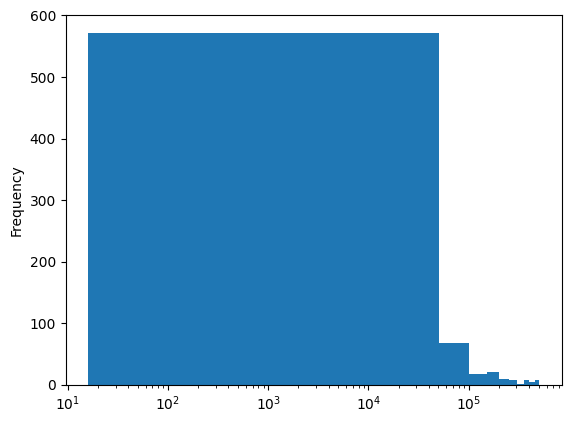

In [183]:
df_soi['Distance To Arrival'].astype(float).plot(kind='hist', logx=True)

In [194]:
df_soi['DATlog'] = np.log10(df_soi['Distance To Arrival'].astype(float))


<Axes: >

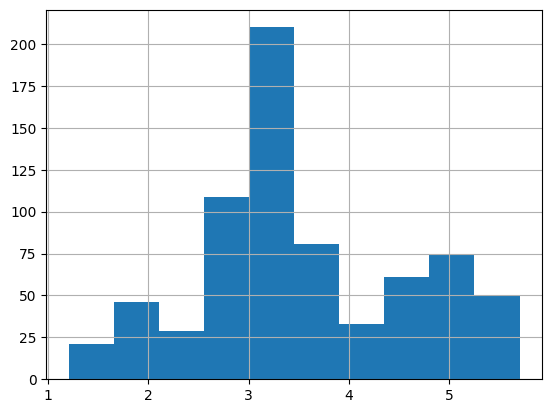

In [195]:
df_soi['DATlog'].hist()

In [176]:
df_soi['Body Sub Type'].value_counts()

Body Sub Type
High metal content world    488
Rocky body                  224
Icy body                      2
Name: count, dtype: int64

In [157]:
body_info = {}
systems_brief ={}

for row in df_soi.reset_index().iterrows():
    data_row = row[1]
    system_name = data_row['System Name'].strip()
    system = systems_db[system_name]
    body_name = f"{system_name} {data_row['Body Name'].strip()}"
    if body_name not in body_info:

        star_bodies = {
            v['bodyId']:len(v['parents']) if v['parents'] is not None else 0
            for v in system['bodies']
            if v['type']=='Star' 
        }
        main_star = [v['bodyId'] for v in system['bodies'] if v.get('isMainStar')][0]
        stars = set(star_bodies.keys())

        body = [B for B in system['bodies'] if B['name'].lower()==body_name.lower()][0]
        body_info[body_name] = body

        parent_star_id = list(
            set(
                [P.get('Star') for P in body['parents'] if 'Star' in P]) &
                stars
        )
        if not parent_star_id:
            parent_star_id = [B['bodyId'] for B in system['bodies'] if B['name'].lower()==system_name.lower()]

        if not parent_star_id:
            parent_stars = sorted(list(star_bodies.keys()), key=lambda x:star_bodies[x])
            print(f"Assuming parent for {body_name} ({body['bodyId']}) kis in {parent_stars}")
        else:
            parent_stars = sorted(parent_star_id, key=lambda x:star_bodies[x], reverse=True)

        body['parent_star_id'] = parent_stars[0]
        
        systems_brief[system_name] = dict(
            bodycount = system['bodyCount'],
            starcount = len(stars),
            mainstar = [v.get('subType','-')[0]  for v in system['bodies'] if v.get('isMainStar')  ],
            stars = '/'.join([v.get('subType','-')[0] for v in system['bodies'] if v['type']=='Star']),

        )

#prettyprint([v['parent_star_id'] for k,v in body_info.items()])

Assuming parent for COL 173 SECTOR JB-F B27-1 BC 3 (14) kis in [1, 3, 4]
Assuming parent for COL 173 SECTOR JI-J B25-0 AB 2 (7) kis in [4, 2, 3]
Assuming parent for COL 173 SECTOR VV-C C13-7 AB 9 A (38) kis in [4, 2, 3]
Assuming parent for EORL AUWSY SY-Z D13-3468 ABC 1 H (21) kis in [1, 24, 3, 4]
Assuming parent for EORL AUWSY SY-Z D13-3468 ABC 3 C (40) kis in [1, 24, 3, 4]
Assuming parent for SYNUEFE TP-F B44-0 CD 1 (16) kis in [2, 3, 5, 6]


In [162]:
gsbrief = pd.DataFrame.from_dict(systems_brief, orient='index')
gsbrief.info()

<class 'pandas.core.frame.DataFrame'>
Index: 314 entries, 2MASS J10444160-5947046 to WREGOE KH-Z B41-0
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   bodycount  314 non-null    int64 
 1   starcount  314 non-null    int64 
 2   mainstar   314 non-null    object
 3   stars      314 non-null    object
dtypes: int64(2), object(2)
memory usage: 12.3+ KB


In [163]:
gsbrief.describe()

,bodycount,starcount
count,314.000000,314.000000
mean,33.117834,2.955414
std,14.994849,1.383813
min,9.000000,1.000000
25%,22.000000,2.000000
50%,30.000000,3.000000
75%,41.000000,3.000000
max,114.000000,15.000000


In [175]:
gsbrief['bodycount'].value_counts().head(25)

bodycount
19    18
30    15
21    15
25    14
29    12
24    12
26    12
35    12
20    10
32     9
18     8
46     8
15     8
42     8
16     7
34     7
28     7
22     7
36     7
31     7
27     6
44     5
39     5
50     5
33     5
Name: count, dtype: int64

<Axes: >

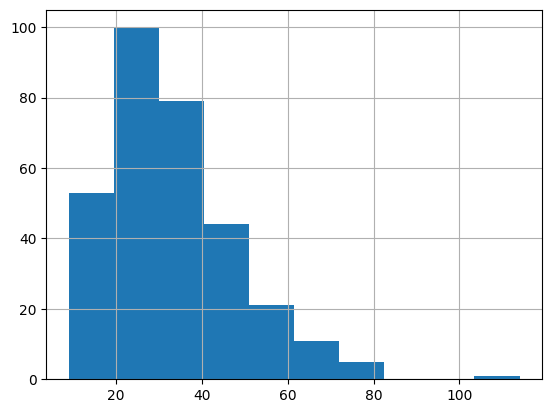

In [165]:
gsbrief['bodycount'].hist()

In [168]:
gsbrief['starcount'].value_counts()

starcount
3     135
2      72
4      47
1      33
5      20
6       4
8       1
15      1
11      1
Name: count, dtype: int64

In [169]:
gsbrief['mainstar'].value_counts()

mainstar
[M]    118
[F]     67
[K]     59
[G]     29
[A]     27
[T]      8
[B]      4
[L]      2
Name: count, dtype: int64

In [171]:
gsbrief['stars'].value_counts().head(20)

stars
M/L      18
F        15
M/M/L    15
M/L/L    14
K/M/L    12
K/M      10
F/Y/Y     8
F/Y       8
M/L/T     7
G         7
K/M/M     7
M/M       7
M/M/M     6
T/T/T     6
M/M/T     6
A         5
F/K       5
A/Y/Y     5
M/T/L     5
M/L/M     5
Name: count, dtype: int64

### Geometric clustering

There is an obvious pattern in the systems that have been discovered

In [ ]:
soi_systemnames = np.asarray(
    [[g]+[r[c] for c in inter_columns] for g in soi for i, r in guardiandata['Guardian '+g].iterrows()] )
soi_coordinates = np.asarray([[r[c] for c in ['x', 'y', 'z']] for g in soi for i, r in guardiandata['Guardian '+g].iterrows()])
print(soi_coordinates.shape, soi_systemnames.shape)

In [ ]:
soi_systems = {r['System Name']:np.asarray([r[c] for c in ['x', 'y', 'z']]) for g in soi for i, r in guardiandata['Guardian '+g].iterrows()}
soi_systemnames = np.asarray(
    [[g]+[r[c] for c in inter_columns] for g in soi for i, r in guardiandata['Guardian '+g].iterrows()] )
soi_coordinates = np.asarray([[r[c] for c in ['x', 'y', 'z']] for g in soi for i, r in guardiandata['Guardian '+g].iterrows()])
print(soi_coordinates.shape, soi_systemnames.shape)

#### Clusters

The guardian systems appear clustered, mostly around points of interest along major galactic travel routes

In [ ]:
from sklearn.cluster import DBSCAN


In [96]:
coord_clusters = DBSCAN(eps=160, min_samples=5).fit(soi_coordinates)
#print(np.unique(coord_clusters.labels_))
#print(np.count_nonzero(np.less(coord_clusters.labels_,0)))
print([(l, np.count_nonzero(np.equal(coord_clusters.labels_,l))) for l in np.unique(coord_clusters.labels_)])


[(-1, 4), (0, 469), (1, 21), (2, 26), (3, 15), (4, 19), (5, 14), (6, 22), (7, 21), (8, 20), (9, 27), (10, 14), (11, 11), (12, 14), (13, 12), (14, 5)]


A few systems do not fall in any cluster

In [97]:
outliers = np.copy(soi_coordinates[np.less(coord_clusters.labels_,0)])
outlier_systemnames = np.copy(soi_systemnames[np.less(coord_clusters.labels_,0)])

pd.DataFrame([[-1]+n.tolist()+c.tolist() for n,c in zip(outlier_systemnames, outliers)])

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-1,Ruins,361,TRAPEZIUM SECTOR YU-X C1-2,573.59375,-339.46875,-1167.65625,K (Yellow-Orange) Star,1 A,Rocky body,...,8.524807315,Alpha,No volcanism,Inner Orion Spur,nan,8.374837745,246,573.59375,-339.46875,-1167.65625
1,-1,Structures,186,TRAPEZIUM SECTOR YU-X C1-2,573.59375,-339.46875,-1167.65625,K (Yellow-Orange) Star,1 A,Rocky body,...,8.524807315,Squid,No volcanism,Inner Orion Spur,nan,8.374837745,246,573.59375,-339.46875,-1167.65625
2,-1,Structures,200,WREGOE BU-Y B2-0,1077.375,400.5625,-993.375,M (Red dwarf) Star,1 C,Icy body,...,11.49914532,Stickyhand,No volcanism,Inner Orion Spur,0.001431,11.49832809,58,1077.37500,400.56250,-993.37500
3,-1,Structures,201,WREGOE BU-Y B2-0,1077.375,400.5625,-993.375,M (Red dwarf) Star,1 C,Icy body,...,11.49914532,Bear,No volcanism,Inner Orion Spur,0.001431,11.49832809,58,1077.37500,400.56250,-993.37500


Write them out to fit the EDAstro custom marker format

In [98]:
with open(f"custom/guardian-clusters.json", 'wt') as of:
    json.dump(dict(markers=[
            dict(
                pin='red',
                text='\n'.join([f"{cn:20}: {v}" for cn, v in zip(['type'] + inter_columns,row[0])]),
                **{c:v for c,v in zip(['x','y','z'], row[1])}
            )
            for row in [(n,c) for n,c in zip(outlier_systemnames, outliers)]
        ] + [
            dict(
                pin='cyan',
                text=f'Center of cluster {row[0]} with {row[2]} guardian sites',
                **{c:v for c,v in zip(['x','y','z'], row[1])}
            )
            for row in [
                (l, np.round(np.mean(soi_coordinates[np.equal(coord_clusters.labels_,l)], axis=0),2).tolist(), np.count_nonzero(np.equal(coord_clusters.labels_,l)) ) 
                for l in np.unique(coord_clusters.labels_) 
                if not l < 0]
        ]), of, indent=3)
    


## Two line ...

In [ ]:
import numpy as np

from scipy.interpolate import interp1d, LinearNDInterpolator


In [ ]:

bkgimage = 'data/visited-systems-indexedregions.png'
bkgimgurl= 'https://edastro.b-cdn.net/mapcharts/visited-systems-indexedregions.png'
bkgimage_scale = 10 # lightyear per pixel
origin=[9000, 7000]
plt_dpi=100

img = plt.imread(bkgimage)


In [ ]:
# fig, ax = plt.subplots(figsize=(img.shape[1]/plt_dpi, img.shape[0]/plt_dpi))
# ax.imshow(img)

# fig.savefig('galaxy.png')


#### Clustering the clusters

We cluster the centers of previously found clusters and calculate a line for each 'line cluster' using 

In [59]:
cluster_centers = np.asarray([
    np.round(np.mean(soi_coordinates[np.equal(coord_clusters.labels_,l)], axis=0),2).tolist() 
    for l in np.unique(coord_clusters.labels_) if l >= 0])
line_clusters = DBSCAN(eps=9999, min_samples=3).fit(cluster_centers)
print([(l, np.count_nonzero(np.equal(line_clusters.labels_,l))) for l in np.unique(line_clusters.labels_)])
guardian_lines = {l:cluster_centers[np.equal(line_clusters.labels_,l)] for l in np.unique(line_clusters.labels_)}

[(0, 5), (1, 10)]


In [99]:
with open(f"custom/two-lines.json", 'wt') as of:
    json.dump(dict(markers=[
            dict(
                pin='yellow', text=f'line 0 {str(row)}',
                **{c:v for c,v in zip(['x','y','z'], row)}
            )
            for row in guardian_lines[0]
        ] + [
            dict(
                pin='green', text=f'line 1 {str(row)}',
                **{c:v for c,v in zip(['x','y','z'], row)}
            )
            for row in guardian_lines[1]
        ]), of, indent=3)

In [139]:
{
    l:np.std(distance_ptl(cluster_centers[np.equal(line_clusters.labels_,l)], **line_from_points(cluster_centers[np.equal(line_clusters.labels_,l)])._asdict()))
    for l in np.unique(line_clusters.labels_)
}

{0: 134.36780623591966, 1: 724.357144983136}

#### Clustering on all systems

Alternatively we can cluster on all systems

In [127]:
import edcompanion.calctools
importlib.reload(edcompanion.calctools)
from edcompanion.calctools import *
from sklearn.cluster import DBSCAN

In [ ]:
line_clusters_ps = DBSCAN(eps=9999, min_samples=3).fit(soi_coordinates)
print([(l, np.count_nonzero(np.equal(line_clusters_ps.labels_,l))) for l in np.unique(line_clusters_ps.labels_)])

guardian_lines = {l:soi_coordinates[np.equal(line_clusters_ps.labels_,l)] for l in np.unique(line_clusters_ps.labels_)}

#### Calculate the lines

In [ ]:
glines = {
    f"line_{l}":line_from_points(soi_coordinates[np.equal(line_clusters_ps.labels_,l)])._asdict()
    for l in np.unique(line_clusters_ps.labels_)
}

In [91]:
with open(f"data/guardian/glines.json", 'wt') as of:
    json.dump(glines,of,indent=3)

In [90]:
print(json.dumps(glines, indent=3))

{
   "line_0": {
      "direction": [
         0.9583869154419554,
         -0.004546140620812322,
         0.2854362501770054
      ],
      "support": [
         1872.7506756756757,
         -159.4177364864865,
         146.18490990990992
      ]
   },
   "line_1": {
      "direction": [
         0.7884621203607939,
         0.019452828555345247,
         0.6147756275401274
      ],
      "support": [
         -1683.7755503144654,
         -477.32626100628926,
         12841.354166666666
      ]
   }
}


Nu even kijken wat het scheelt

In [89]:
{
    l:np.std(distance_ptl(cluster_centers[np.equal(line_clusters.labels_,l)], **line_from_points(soi_coordinates[np.equal(line_clusters_ps.labels_,l)])._asdict()))
    for l in np.unique(line_clusters.labels_)
}

{0: 161.60832343689987, 1: 760.893264214019}

In [115]:
{
    l:np.dot(cluster_centers[np.equal(line_clusters.labels_,l)], line_from_points(soi_coordinates[np.equal(line_clusters_ps.labels_,l)]).direction).shape
    for l in np.unique(line_clusters.labels_)
}

{0: (5,), 1: (10,)}

In [128]:
gsystem_lines = {
    l:line_from_points(soi_coordinates[np.equal(line_clusters_ps.labels_,l)])._asdict()
    for l in np.unique(line_clusters_ps.labels_)
}


In [137]:
gsystem_lines

{0: {'direction': array([ 0.95838692, -0.00454614,  0.28543625]),
  'support': array([1872.75067568, -159.41773649,  146.18490991])},
 1: {'direction': array([0.78846212, 0.01945283, 0.61477563]),
  'support': array([-1683.77555031,  -477.32626101, 12841.35416667])}}

In [144]:
with open(f"custom/projected-clusters.json", 'wt') as of:
        json.dump(dict(markers=[
        dict(
            pin='yellow',
            text=f"cluster {l}, distance {round(distance_point_tol_line(cc, **gsystem_lines[l]),1)}\ncentre \t{cc}\nprojected \t{project_point_on_line(cc, **gsystem_lines[l])}",
            **{c:round(v,1) for c,v in zip(['x','y','z'], list(project_point_on_line(cc, **gsystem_lines[l])))}
        )
        for l in np.unique(line_clusters.labels_) 
        for cc in cluster_centers[np.equal(line_clusters.labels_,l)]
        if not l < 0
    ]),of,indent=3)

### Intersect

In [ ]:
from numpy import empty_like, dot, array
def perp( a ) :
    b = empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return 
def seg_intersect(a1,a2, b1,b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = dot( dap, db)
    num = dot( dap, dp )
    return (num / denom.astype(float))*db + b1

def ppol(point, line_dir, line_mean):
    return np.dot(np.asarray(point)-line_mean, line_dir) * line_dir + line_mean


#### Scikit-spatial intersection

In [ ]:
from skspatial.objects import Line
from skspatial.plotting import plot_3d


line_a = Line(
    point=[glines['line_0']['mean'][0],0,glines['line_0']['mean'][2]] ,
    direction=[glines['line_0']['direction'][0],0,glines['line_0']['direction'][1]]
)
line_b = Line(
    point=[glines['line_1']['mean'][0],0,glines['line_1']['mean'][2]] ,
    direction=[glines['line_1']['direction'][0],0,glines['line_1']['direction'][1]]
)

guardian_home = line_a.intersect_line(line_b)


In [ ]:
with open(f"custom/guardian-intersect.json", 'wt') as of:
    json.dump(dict(markers=[
            dict(
                pin='white', text=f'intersect {str(guardian_home)}',
                y=0,
                **{c:round(v) for c,v in zip(['x','z'], guardian_home.tolist())}
            )
            
        ]), of, indent=3)

#### Using a homebrew method with interp1d

In [ ]:
line_0 = interp1d(guardian_lines[0][:,0], guardian_lines[0][:,2], fill_value='extrapolate')
line_1 = interp1d(guardian_lines[1][:,0], guardian_lines[1][:,2], fill_value='extrapolate')


In [ ]:
x0 = [np.min(guardian_lines[0][:,0]), np.max(guardian_lines[0][:,0])]
z0 = line_0(x0)
x0,z0

p0 = np.column_stack((x0,z0))

In [ ]:
x1 = [np.min(guardian_lines[1][:,0]), np.max(guardian_lines[1][:,0])]
z1 = line_1(x1)
p1 = np.column_stack((x1,z1))

In [ ]:
p0,p1

In [ ]:
guardian_home = seg_intersect(p0[0],p0[1], p1[0],p1[1])
with open(f"custom/guardian-intersect.json", 'wt') as of:
    json.dump(dict(markers=[
            dict(
                pin='white', text=f'intersect {str(guardian_home)}',
                y=0,
                **{c:round(v) for c,v in zip(['x','z'], guardian_home.tolist())}
            )
            
        ]), of, indent=3)

In [ ]:
guardian_home

In [ ]:
from edcompanion.edsm_api import get_systems_in_cube

[ 
    get_systems_in_cube(system=[guardian_home[0], y, guardian_home[1]]) 
    for y in range(-2000,2000, 100)
]


In [ ]:
target_point = np.array([0,0])
target_point = np.array([ -22761.6875 , -3380.84375]) # DSSA Maerzenbecher

np.linalg.norm(np.cross(guardian_home-p1[0], p1[0]-target_point))/np.linalg.norm(guardian_home-p1[0])

In [ ]:
np.linalg.norm(np.cross(guardian_home-p0[0], p0[0]-target_point))/np.linalg.norm(guardian_home-p0[0])

In [ ]:
#p3=target_point
target_point = np.array([ -22761.6875 , -3380.84375]) # DSSA Maerzenbecher
#p1=guardian_home
#p2=p1[0]
#The line extending the segment is parameterized as p1 + t (p2 - p1).
#The projection falls where t = [(p3-p1) . (p2-p1)] / |p2-p1|^2
l2 = np.sum((guardian_home-p1[0])**2)
#if you need the point to project on line extention connecting p1 and p2
t = np.sum((target_point - guardian_home) * (p1[0] - guardian_home)) / l2

#if you need to ignore if p3 does not project onto line segment
if t > 1 or t < 0:
  print('p3 does not project onto p1-p2 line segment')

#if you need the point to project on line segment between p1 and p2 or closest point of the line segment
t = max(0, min(1, np.sum((target_point - guardian_home) * (p1[0] - guardian_home)) / l2))

projection1 = guardian_home + t * (p1[0] - guardian_home)

In [ ]:
#p3=target_point
target_point = np.array([  -15755.34375 , 107.0625 ])
#p1=guardian_home
#p2=p1[0]
#The line extending the segment is parameterized as p1 + t (p2 - p1).
#The projection falls where t = [(p3-p1) . (p2-p1)] / |p2-p1|^2
l2 = np.sum((guardian_home-p1[0])**2)
#if you need the point to project on line extention connecting p1 and p2
t = np.sum((target_point - guardian_home) * (p1[0] - guardian_home)) / l2

#if you need to ignore if p3 does not project onto line segment
if t > 1 or t < 0:
  print('p3 does not project onto p1-p2 line segment')

#if you need the point to project on line segment between p1 and p2 or closest point of the line segment
t = max(0, min(1, np.sum((target_point - guardian_home) * (p1[0] - guardian_home)) / l2))

projection2 = guardian_home + t * (p1[0] - guardian_home)

In [ ]:
projection2

In [ ]:
from edcompanion.edsm_api import get_systems_in_cube

[ 
    get_systems_in_cube(system=[target_point[0], y, target_point[1]]) 
    for y in range(-2000,2000, 100)
]


In [ ]:
#p3=target_point SYREADIAE JX-F C0
target_point = np.array([ -9529.4375, -7428.4375])
#p1=guardian_home
#p2=p1[0]
#The line extending the segment is parameterized as p1 + t (p2 - p1).
#The projection falls where t = [(p3-p1) . (p2-p1)] / |p2-p1|^2
l2 = np.sum((guardian_home-p1[0])**2)
#if you need the point to project on line extention connecting p1 and p2
t = np.sum((target_point - guardian_home) * (p1[0] - guardian_home)) / l2

#if you need to ignore if p3 does not project onto line segment
if t > 1 or t < 0:
  print('p3 does not project onto p1-p2 line segment')

#if you need the point to project on line segment between p1 and p2 or closest point of the line segment
t = max(0, min(1, np.sum((target_point - guardian_home) * (p1[0] - guardian_home)) / l2))

projection3 = guardian_home + t * (p1[0] - guardian_home)

In [ ]:

with open(f"custom/guardian-intersect.json", 'wt') as of:
    json.dump(dict(markers=[
            dict(
                pin='white', text=f'intersect {str(guardian_home)}',
                y=0,
                **{c:round(v) for c,v in zip(['x','z'], guardian_home.tolist())}
            ),
            dict(
                pin='red', text=f'project DSSA Maerzenbecher {str(projection1)}',
                y=0,
                **{c:round(v) for c,v in zip(['x','z'], projection1.tolist())}
            ),
            dict(
                pin='red', text=f'project Hemi Cuda {str(projection2)}',
                y=0,
                **{c:round(v) for c,v in zip(['x','z'], projection2.tolist())}
            ),
            dict(**{
                    "pin": "red",
                    "text": "Syreadiae JX-F c0 \n -9529.4375 / -64.5 / -7428.4375",
                    "y": -64.5,
                    "x": -9529.4375,
                    "z": -7428.4375
                }            
            )
            
        ]), of, indent=3)

In [ ]:
projection

## Beacons

In [ ]:
with open(f"custom/beacons.json", 'wt') as of:
    json.dump(dict(markers=[
            dict(
                pin='yellow',
                text=f"{row['System Name']:24} Body: {row['Body Name']} {row['Distance To Arrival']}\n{row['Guardian Structure System']}",
                **{c:row[c] for c in ['x','y','z']}
            )
            for i, row in guardiandata['Guardian Beacons'].iterrows()
        ] ), of, indent=3)

In [ ]:
list(guardiandata['Guardian Beacons'].iterrows())[0][1]

In [ ]:
guardiandata['Guardian Beacons']

In [ ]:
pd.DataFrame([ 
    [l]+n.tolist()+c.tolist() 
    for l in np.unique(coord_clusters.labels_) 
    for n,c in zip(
        soi_systemnames[np.equal(coord_clusters.labels_,l)], 
        soi_coordinates[np.equal(coord_clusters.labels_,l)] )
])

In [ ]:
pd.DataFrame([ 
    [l]+n.tolist()+c.tolist() 
    for l in np.unique(coord_clusters.labels_) 
    for n,c in zip(
        soi_systemnames[np.equal(coord_clusters.labels_,l)], 
        soi_coordinates[np.equal(coord_clusters.labels_,l)] )
])

In [ ]:
write_markers('guardian-clusters', dict(
    red=[
        dict(
            name=str(row[2]), type=str(row[1]), body=f"{row[3]} - {row[4]}",
            x=row[6], y=row[7], z=row[8], distance=row[5] ) 
        for index, row in pd.read_csv('data/Guardian - Ruins.csv').iterrows() 
    ],
))

In [ ]:

outlier_clusters = DBSCAN(eps=200, min_samples=2).fit(outliers)
#print(np.unique(outlier_clusters.labels_))
#print(np.count_nonzero(np.less(outlier_clusters.labels_,0)))
pd.DataFrame([(l, np.count_nonzero(np.equal(outlier_clusters.labels_,l))) for l in np.unique(outlier_clusters.labels_)]).set_index(0)

In [ ]:
really_lonely = np.copy(outliers[np.less(outlier_clusters.labels_,0)])
really_lonely_systemnames = np.copy(outlier_systemnames[np.less(outlier_clusters.labels_,0)])

#print(really_lonely, really_lonely_systemnames)
pd.DataFrame([n.tolist()+c.tolist() for n,c in zip(really_lonely_systemnames, really_lonely)])

In [ ]:

for n,c in zip(really_lonely_systemnames, really_lonely)

In [ ]:
write_markers('guardian-isolated', dict(
    red=[
        dict(name=str(row['System Name']), type=str(row['Type(s)']), body=str(row['Body'])) 
        for index, row in pd.read_csv('data/Guardian - Ruins.csv').iterrows() 
    ],
))

In [ ]:
really_lonely

In [ ]:
pd.DataFrame(outlier_systemnames)

In [ ]:
for n, df in guardiandata.items():
    print(f"{n} - {len(df)}\n{set(df.columns)}\n\n")

In [ ]:
soi = ['Ruins','Structures','Beacons']
inter_columns = list([i for i in accumulate([set(guardiandata['Guardian '+n].columns) for n in soi], lambda D1, D2: D1 & D2)][-1])
union_columns = list([i for i in accumulate([set(guardiandata['Guardian '+n].columns) for n in soi], lambda D1, D2: D1 | D2)][-1])

column_order_inter = {c:i for c,i in zip(guardiandata['Guardian Beacons'].columns, range(len(guardiandata['Guardian Beacons'].columns))) }
inter_columns = sorted(inter_columns, key=lambda I:column_order_inter.get(I,100))
union_columns = sorted(union_columns, key=lambda I:column_order_inter.get(I,100))

In [ ]:
pd.concat([guardiandata['Guardian '+n][inter_columns] for n in soi]).sort_values('Body Name')

In [ ]:
inter_columns
    

In [ ]:
l = [set(guardiandata['Guardian '+n].columns) for n in ['Ruins','Structures','Beacons']]

In [ ]:
l

# Dividing the Galaxy

In [ ]:
# get the extend of the explored galaxy
qx = await pgpool.fetchrow("SELECT min(c20x), max(c20x) from systems")
qy = await pgpool.fetchrow("SELECT min(c20y), max(c20y) from systems")
qz = await pgpool.fetchrow("SELECT min(c20z), max(c20z) from systems")
print([(R.get("min"), R.get("max"), R.get("max")-R.get("min")) for R in [qx, qy, qz]])

In [ ]:
# get the extend of the explored galaxy
qx = await pgpool.fetchrow("SELECT min(x), max(x) from systems")
qy = await pgpool.fetchrow("SELECT min(y), max(y) from systems")
qz = await pgpool.fetchrow("SELECT min(z), max(z) from systems")
print([(R.get("min"), R.get("max"), R.get("max")-R.get("min")) for R in [qx, qy, qz]])

In [ ]:
rx = 

In [ ]:
known_extend = [(-42213.8125, 40503.8125, 82717.625), (-29359.8125, 39518.34375, 68878.15625), (-23405.0, 65630.15625, 89035.15625)]

In [ ]:
counts = [(int(math.floor(v[2]/200))) for v in known_extend]
print(counts)

In [ ]:
counts[0] * counts[1] * counts[2]

In [ ]:
pow(len(range(-40000, 40000, 200)),3)/pow(100,3)

In [ ]:
Xr, *YZ = [(int(200*math.floor(R.get("min")/200)) , int(200*math.floor(R.get("max")/200))) for R in [qx, qy, qz]]

In [ ]:
len(range(*Xr, 200))

In [ ]:
Yr, *Z = YZ

In [ ]:
len(range(*Yr, 200))

In [ ]:
Zr, *T = Z

In [ ]:
len(range(*Zr, 200))

In [ ]:
data = []
count = 0
start = time.process_time()

for cy in range(-3000, 3000, 200): # n=30
    count += 1
    qr = await pgpool.copy_records_to_table("volumes", records=[(cx,cy,cz)  for cx in range(-30000, 30000, 200) for cz in range(-24000, 66000,200)])
    print(f"{count}/{30}\t{round(100*count/30,2)}%, {round(((30 - count) * (time.process_time() - start)/count),1)} remaining")



In [ ]:
cy=0

In [ ]:
[(cx,cy,cz)  for cx in range(-30000, 30000, 2000) for cz in range(-24000, 66000,2000)]

In [ ]:
len(range(-24000, 66000, 200)) * len(range(-30000, 30000, 200)) * len(range(-3000, 3000, 200)) / 1000

In [ ]:
len(range(-30000, 30000, 200))